### 1. Import Libraries

In [2]:
import os
import time

# data science libraries
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

### 2. Load Data

In [3]:
movies = pd.read_csv(r'C:\Users\Ravikumar\Anaconda Programs\Dataset\Movielens10M\movies.csv')
#print(type(movies))
movies.head()
#movies.info()
#movies.isnull().sum()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
tags = pd.read_csv(r'C:\Users\Ravikumar\Anaconda Programs\Dataset\Movielens10M\tags.csv')
#print(type(tags))
tags.head()
#tags.info()
#tags.isnull().sum()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
ratings = pd.read_csv(r'C:\Users\Ravikumar\Anaconda Programs\Dataset\Movielens10M\ratings.csv', sep=',', parse_dates=['timestamp'])
#print(type(ratings))
ratings.head()
#ratings.info()
#ratings.isnull().sum()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
num_users = len(ratings.userId.unique())
num_movies = len(ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_movies))

There are 610 unique users and 9724 unique movies in this data set


### 3. Data Analysis
#### i) Plot the counts of each rating

In [8]:
# get counts of each rating from ratings file
ratings_cnt_tmp = pd.DataFrame(ratings.groupby('rating').size(), columns=['count'])
ratings_cnt_tmp.head(10)

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


Above table does not include counts of zero rating score. So we need to add that in rating count dataframe

In [9]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_movies
rating_zero_cnt = total_cnt - ratings.shape[0]
# append counts of zero rating to ratings_cnt
ratings_cnt = ratings_cnt_tmp.append(pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]), verify_integrity=True,).sort_index()
ratings_cnt.head(12)

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


The count for zero rating score is too big to compare with others. Take log transform for count values and then plot them to compare

In [10]:
# add log count
ratings_cnt['log_count'] = np.log(ratings_cnt['count'])
ratings_cnt

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


Text(0, 0.5, 'Number of ratings')

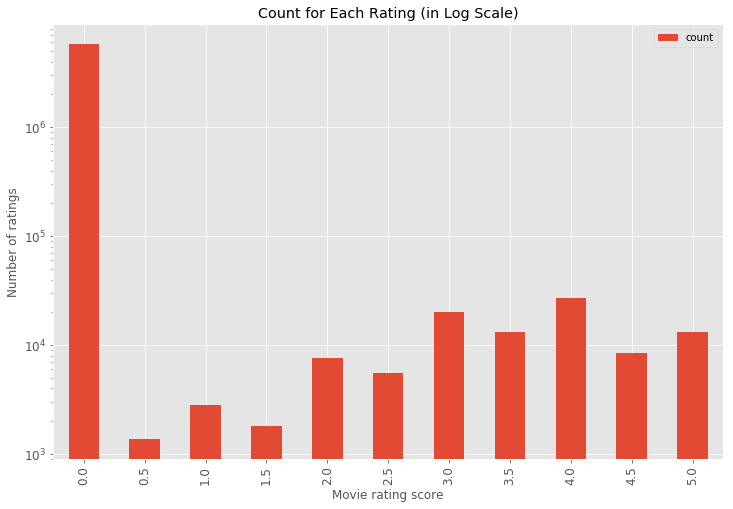

In [11]:
# plot each rating score
ax = ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("Movie rating score")
ax.set_ylabel("Number of ratings")

#### ii) Plot rating frequency of all movies

In [12]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [13]:
# get rating frequency
movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
movies_cnt.head()

,count
movieId,
1,215
2,110
3,52
4,7
5,49


Text(0, 0.5, 'Number of ratings')

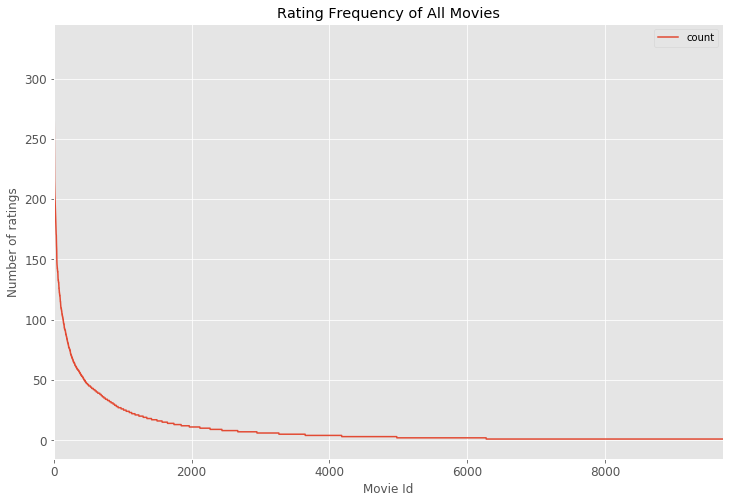

In [14]:
# plot rating frequency of all movies
ax = movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("Movie Id")
ax.set_ylabel("Number of ratings")

Above graph is referred as the Long-tail property, according to this, only a small fraction of the movies are rated frequently. 
Such movies are referred to as popular movies.

Plot the same graph with log scale.

Text(0, 0.5, 'Number of ratings (log scale)')

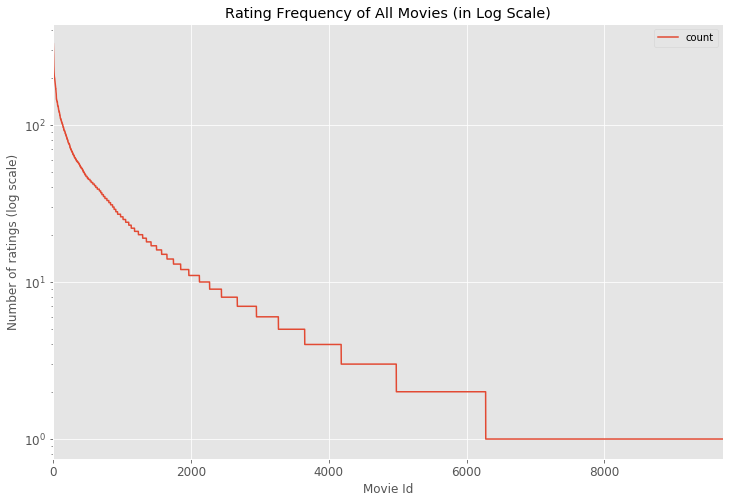

In [15]:
# plot rating frequency of all movies in log scale
ax = movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("Movie Id")
ax.set_ylabel("Number of ratings (log scale)")

We can see that roughly 2,000 out of 9,742 movies are rated more than 10 times. More interestingly, roughly 4,000 out of 9,742 movies are rated less than 10 times. Let's look closer by displaying top quantiles of rating counts

In [16]:
movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

So about 1% of movies have roughly 329 or more ratings, 5% have 40 or more, and 20% have 20 or more ratings. Since we have so many movies, we limit it to the top 25%. This is arbitrary threshold for popularity, We still have pretty good amount of movies for modeling. There are two reasons why we want to filter movies in our dataset.
 - Memory Issue: Avoiding the “MemoryError” during model training
 - Improve KNN performance: lesser known movies have ratings from fewer viewers, making the pattern more noisy. Droping out less known movies can improve recommendation quality

In [17]:
# filter data
popularity_thres = 50
popular_movies = list(set(movies_cnt.query('count >= @popularity_thres').index))
ratings_drop_movies = ratings[ratings.movieId.isin(popular_movies)]
print('Shape of original ratings data: ', ratings.shape)
print('Shape of ratings data after dropping unpopular movies: ', ratings_drop_movies.shape)

Shape of original ratings data:  (100836, 4)
Shape of ratings data after dropping unpopular movies:  (41360, 4)


After dropping 75% of movies, we still have a large dataset. So next we can filter users to further reduce the size of data.

In [18]:
# get number of ratings given by every user
users_cnt = pd.DataFrame(ratings_drop_movies.groupby('userId').size(), columns=['count'])
users_cnt.head()

,count
userId,
1,117
2,15
3,6
4,84
5,34


Text(0, 0.5, 'Number of ratings')

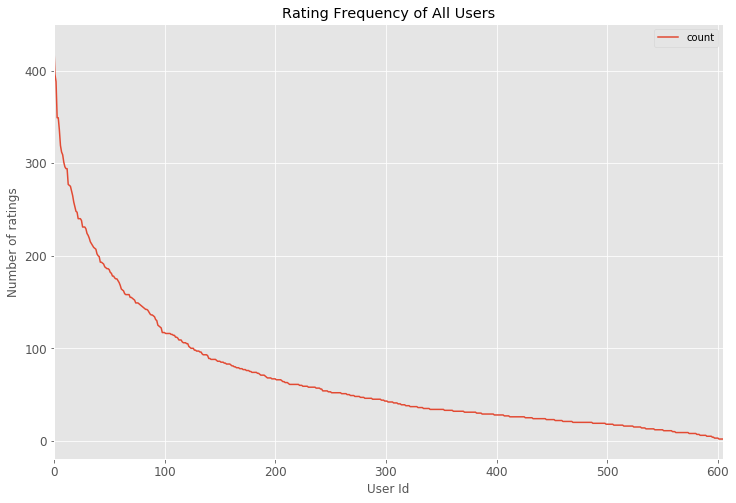

In [19]:
# plot rating frequency of all movies
ax = users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("User Id")
ax.set_ylabel("Number of ratings")

In [20]:
users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    429.00
0.95    223.50
0.90    166.00
0.85    134.25
0.80    105.00
0.75     85.00
0.70     74.00
0.65     62.25
0.60     56.00
0.55     48.00
Name: count, dtype: float64

We can see that the distribution of ratings by users is slightly similar to the distribution of ratings among movies. They both have long-tail property. Only a very small fraction of users are very actively engaged with rating movies that they watched. Vast majority of users aren't interested in rating movies. So we can limit users to the top 40%.

In [21]:
# filter data
ratings_thres = 50
active_users = list(set(users_cnt.query('count >= @ratings_thres').index))
ratings_drop_users = ratings_drop_movies[ratings_drop_movies.userId.isin(active_users)]
print('Shape of original ratings data: ', ratings.shape)
print('Shape of ratings data after dropping both unpopular movies and inactive users: ', ratings_drop_users.shape)

Shape of original ratings data:  (100836, 4)
Shape of ratings data after dropping both unpopular movies and inactive users:  (32999, 4)


### 4. Train KNN model for Item-based Collaborative filtering


#### I). Reshaping the Data
For K-Nearest Neighbors, we want the data to be in an array, where each row is a movie and each column is a different user.
To reshape the dataframe, we'll pivot the dataframe with movies as rows and users as columns. Then we'll fill the missing observations with 0s since we're going to be performing linear algebra operations (calculating distances between vectors). Finally, we transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [22]:
# pivot and create movie-user matrix
movie_user_mat = ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

#### ii). Fitting the Model
We initialize the NearestNeighbors class as model_knn and fit our sparse matrix to the instance. The model will measure similarity bectween artist vectors by using cosine similarity.

In [23]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=20, p=2, radius=1.0)

### 5. Use trained model to make recommendations!

In [24]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
 
    # fit
    model_knn.fit(data)
    # get input movie index
    print('Search movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('........\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [25]:
my_favorite = 'Ironman'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

Search movie: Ironman
Found possible matches in our database: ['Iron Man (2008)']

Recommendation system start to make inference
........

Recommendations for Ironman:
1: Batman Begins (2005), with distance of 0.34744154173084363
2: Sherlock Holmes (2009), with distance of 0.3463540530285869
3: Kung Fu Panda (2008), with distance of 0.34323498779508776
4: Inception (2010), with distance of 0.33073992134058794
5: District 9 (2009), with distance of 0.3187720802539473
6: Up (2009), with distance of 0.31706735090314886
7: WALL·E (2008), with distance of 0.27033112296383466
8: Avengers, The (2012), with distance of 0.2610290662950412
9: Avatar (2009), with distance of 0.2599024893009969
10: Dark Knight, The (2008), with distance of 0.24019004841992464


This is very interesting that **KNN** model recommends movies that were also produced in very similar years. However, the cosine distance of all those recommendations are actually quite small. It is because there is too many zero values in our movie-user matrix. The data sparsity becomes a real issue for **KNN** model.

### Addition (Future Implementation)
##### I) Missing data
Let's look at how sparse the movie-user matrix is by calculating percentage of zero values in the data.

In [102]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_user_mat.shape[0] * movie_user_mat.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_user_mat==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 93.94% of ratings in our data is missing


#### II) Displaying links to the Image files (movie poster) using API

In [4]:
links = pd.read_csv(r'C:\Users\Ravikumar\Anaconda Programs\Dataset\Movielens10M\links.csv')
print(type(links))
links.head()
links.info()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
imdbId     9742 non-null int64
tmdbId     9734 non-null float64
dtypes: float64(1), int64(2)
memory usage: 228.4 KB
